In [17]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
import copy
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plyfile import PlyData, PlyElement

## Exporting to PLY

In [45]:
def generate_vertex_data_from_arr(X, Y, Z):
    """Returns a PlyElement listing each vertex of data."""

    # Create a list of vertices.
    vertex_data_points = []

    for r_idx in range(len(Y)):
        for c_idx in range(len(Y[0])):
            z, vx, vy, vz = 0, 0.0, 0.0, 0.0
            
            x = X[r_idx][c_idx]
            y = Y[r_idx][c_idx]
            s = Z[r_idx][c_idx]
            vertex_data_points.append((x, y, z, vx, vy, vz, s))
        
    # Export the list of vertices.
    # numpy data types: ['int8', 'i1', 'char', 'uint8', 'u1', 'uchar', 'b1', 'int16', 'i2', 'short', 'uint16', 'u2', 'ushort', 'int32', 'i4', 'int', 'uint32', 'u4', 'uint', 'float32', 'f4', 'float', 'float64', 'f8', 'double']
    vertices = np.array(vertex_data_points,
                         dtype=[('x', 'float64'), ('y', 'float64'), ('z', 'float64'),
                                ('vx', 'float64'), ('vy', 'float64'), ('vz', 'float64'),
                                ('s', 'float64')])

    return PlyElement.describe(vertices, 'vertex')

In [42]:
def generate_face_data(num_rows):
    """Returns a PlyElement listing all of the faces of a square plane.
       Params:
            - num_rows = an int equal to the number of rows/cols of data, i.e. number of vertices in a direction.
    """
    row_size = num_rows - 1
    num_faces = row_size**2

    # For every face, insert it into `data` as a tuple, which we will turn into a PlyElement.
    data = []
    x = 0
    while x < num_faces + row_size:
        if x % row_size - (x // row_size - 1) == 0:
            x += 1
            continue

        next_row_offset = row_size + 2 + x
        data.append(([x, x + 1, next_row_offset, next_row_offset - 1]))
        x += 1

    face_data = np.array(data,
                            dtype=[('vertex_indices', 'int32', (4,))])

    # PlyElement.describe requires a one-dimensional structured array, so we have to do this in two lines.
    ply_faces = np.empty(len(face_data),
                            dtype=[('vertex_indices', 'int32', (4,))])
    ply_faces['vertex_indices'] = face_data

    element_2 = PlyElement.describe(ply_faces, 'face')
    return element_2

In [44]:
def output_ply(name, X, Y, Z):
    """Outputs a ply file for a square scalar field of vertices at (x = X[i], y = Y[i], s = Z[i])."""

    output_filename = f'new_data_{name}.ply'
    # Generate the face and vertex elements.
    num_rows = len(X)
    vertex_element = generate_vertex_data_from_arr(X, Y, Z)
    face_element = generate_face_data(num_rows)

    # Create a PlyData object and write it to a file.
    new_ply_data = PlyData([vertex_element, face_element], text=True)
    new_ply_data.write(output_filename)

    print(f"Saved to {output_filename}")

---

## Training the model

In [ ]:
def get_data():
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    
    training_data = torchvision.datasets.CIFAR10(root = 'data',
                                               train = True,
                                               transform = transform,
                                               download = True)

    testing_data = torchvision.datasets.CIFAR10(root = 'data',
                                              train = False,
                                              transform = transform,
                                              download=True)
    
    return training_data, testing_data

def get_loaders(training_data, testing_data, batch_size):
    training_loader = torch.utils.data.DataLoader(dataset = training_data,
                                                  batch_size = batch_size,
                                                  shuffle = True)

    testing_loader = torch.utils.data.DataLoader(dataset = testing_data,
                                                 batch_size = batch_size,
                                                 shuffle = True)
    
    return training_loader, testing_loader

In [ ]:
def train(model, training_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    num_correct = 0
    print("Training")
    for i, data in enumerate(training_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 50):
            break
        # print("Training i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
        loss.backward()
        optimizer.step()
    
    # TODO: remove this, just here to cut down on running time
    loss = running_loss/(10*50)
    #loss = running_loss/len(training_loader.dataset)
    accuracy = num_correct/ (10*50)
    #accuracy = num_correct/len(training_loader.dataset)
    print(f'Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}')
    
    return loss, accuracy

def test(model, testing_loader, criterion):
    model.eval()
    running_loss = 0.0
    num_correct = 0
    for i, data in enumerate(testing_loader):
        # TODO: remove this, just here to cut down on running time
        if(i == 10):
            break
        # print("Testing i:" + str(i))
        data, labels = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, labels)
        running_loss += loss.item()
        _, predictions = torch.max(output.data, 1)
        num_correct += (predictions == labels).sum().item()
    
    # TODO: remove this, just here to cut down on running time
    loss = running_loss/(10*10)
    #loss = running_loss/len(testing_loader.dataset)
    accuracy = num_correct/(10*10)
    #accuracy = num_correct/len(testing_loader.dataset)
    print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}')
    
    return loss, accuracy

def pre_train_and_test(model, training_loader, testing_loader, criterion, optimizer):
    training_historical_loss, training_historical_accuracy = [], []
    testing_historical_loss, testing_historical_accuracy = [], []

    # TODO: make larger,
    for epoch in range(1):
        print("epoch: " + str(epoch))
        training_loss, training_accuracy = train(model, training_loader, criterion, optimizer)
        testing_loss, testing_accuracy = test(model, testing_loader, criterion)
        training_historical_loss.append(training_loss)
        training_historical_accuracy.append(training_accuracy)
        testing_historical_loss.append(testing_loss)
        testing_historical_loss.append(testing_accuracy)
        
    return  training_historical_loss, testing_historical_loss

In [ ]:
def get_weights(model):
    return [param.data for param in model.parameters()]

def get_random_directions(weights, device):
    return [torch.randn(w.size()).to(device) for w in weights]

def normalize_directions(directions, weights):
    for d, w in zip(directions, weights):
        d.mul_(w.norm()/(d.norm() + 1e-10))

def tensorlist_to_tensor(weights):
    return torch.cat([w.cpu().view(w.cpu().numel()) if w.dim() > 1 else torch.FloatTensor(w.cpu()) for w in weights])

def get_diff_weights(final_weights, historical_weights):
    return [w2 - w for (w, w2) in zip(final_weights, historical_weights)]


In [34]:
def plot_figure(X, Y, Z, title):
    fig = plt.figure(figsize=(10,7.5))
    ax0 = fig.add_subplot(projection='3d' )

    ax0.view_init(elev=30, azim=-20)
    ax0.set_xlabel('X', labelpad=9)
    ax0.set_ylabel('Y', labelpad=-5)
    ax0.set_zlabel("Loss", labelpad=-30)
    ax0.tick_params(axis='x', pad=5, which='major')
    ax0.tick_params(axis='y', pad=-5, which='major')
    ax0.tick_params(axis='z', pad=5, which='major')
    ax0.set_title(title, y=0.85)
    ax0.plot_surface(X, Y, Z, cmap='terrain', antialiased=True, cstride=1, rstride=1, alpha=0.75)

    plt.show()
    print("X data:")
    print(X)
    print("Y data:")
    print(Y)
    print("Z data:")
    print(Z)

In [ ]:
def get_random_direction_losses(model, testing_loader, criterion, device):
    
    weights = get_weights(model)

    random_x_directions = get_random_directions(weights, device);
    random_y_directions = get_random_directions(weights, device);

    normalize_directions(random_x_directions, weights);
    normalize_directions(random_y_directions, weights);

    x_coordinates = np.arange(-0.1, 0.125, 0.025)   
    y_coordinates = np.arange(-0.1, 0.125, 0.025)  
    X, Y = np.meshgrid(x_coordinates, y_coordinates)
    Z = np.zeros((x_coordinates.size, y_coordinates.size))

    for y_index, y in enumerate(y_coordinates):
        for x_index, x in enumerate(x_coordinates):
        
            print("X: " + str(x))
            print("Y: " + str(y))
        
            updated_x_directions = [direction * x for direction in random_x_directions]
            updated_y_directions = [direction * y for direction in random_y_directions]
            delta = [sum(direction) for direction in zip(updated_x_directions, updated_y_directions)]
            old_weights = copy.deepcopy(get_weights(model))
        
            for (p, w, d) in zip(model.parameters(), old_weights, delta):
                p.data = w + torch.Tensor(d).type(type(w)).to(device)
            
            testing_loss, testing_accuracy = test(model, testing_loader, criterion)
            Z[y_index][x_index] = testing_loss
        
            for (p, w) in zip(model.parameters(), old_weights):
                p.data = w
                
    return X, Y, Z

In [ ]:
def pca_to_directions(pca, weights):
      directions = copy.deepcopy(weights)
      idx = 0
      for w in directions:
          w.copy_(torch.tensor(pca[idx:idx + w.numel()]).view(w.size()))
          idx += w.numel()
      return directions

In [ ]:
def get_pca_losses(model, training_loader, testing_loader, criterion, device, optimizer):

    historical_weights = []
    for epoch in range(2):
        train(model, training_loader, criterion, optimizer)
        training_weights = get_weights(model)
        historical_weights.append(training_weights)

    weight_change_directions = []
    for weight in historical_weights:
      weight_change_direction = get_diff_weights(weight, historical_weights[-1])
      weight_change_directions.append(tensorlist_to_tensor(weight_change_direction).numpy())

    pca = PCA(n_components=2)
    pca.fit(np.array(weight_change_directions))
    pca1 = np.array(pca.components_[0])
    pca2 = np.array(pca.components_[1])

    pca_x_directions = pca_to_directions(pca1, historical_weights[-1])
    pca_y_directions = pca_to_directions(pca2, historical_weights[-1])

    x_coordinates = np.arange(-0.1, 0.125, 0.025)   
    y_coordinates = np.arange(-0.1, 0.125, 0.025)  

    X, Y = np.meshgrid(x_coordinates, y_coordinates)
    Z = np.zeros((x_coordinates.size, y_coordinates.size))

    for y_index, y in enumerate(y_coordinates):
        for x_index, x in enumerate(x_coordinates):

            # print("X: " + str(x))
            # print("Y: " + str(y))
            updated_x_directions = [direction * x for direction in pca_x_directions]
            updated_y_directions = [direction * y for direction in pca_y_directions]
            delta = [sum(direction) for direction in zip(updated_x_directions, updated_y_directions)]
            old_weights = copy.deepcopy(get_weights(model))

            for (p, w, d) in zip(model.parameters(), old_weights, delta):
                p.data = w + torch.Tensor(d).type(type(w)).to(device)
            
            testing_loss, testing_accuracy = test(model, testing_loader, criterion)
            Z[y_index][x_index] = testing_loss
        
            for (p, w) in zip(model.parameters(), old_weights):
                p.data = w
        

    return X, Y, Z

In [50]:
def create_random_direction_loss_landscape(model, testing_loader, criterion, device, graph_title):
    X, Y, Z = get_random_direction_losses(model, testing_loader, criterion, device)
    plot_figure(X, Y, Z, graph_title)
    output_ply(f"{graph_title.replace(' ', '_')}_random", X, Y, Z)

def create_pca_loss_landscape(model, training_loader, testing_loader, criterion, device, optimizer, graph_title):
    X, Y, Z = get_pca_losses(model, training_loader, testing_loader, criterion, device, optimizer)
    plot_figure(X, Y, Z, graph_title)
    output_ply(f"{graph_title.replace(' ', '_')}_pca", X, Y, Z)


In [ ]:
def create_loss_landscapes(model, training_loader, testing_loader, device, graph_title):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    training_historical_loss, testing_historical_loss = pre_train_and_test(model, training_loader, testing_loader, criterion, optimizer)
    create_pca_loss_landscape(model, training_loader, testing_loader, criterion, device, optimizer, graph_title + " PCA")
    create_random_direction_loss_landscape(model, testing_loader, criterion, device, graph_title + " Random Directions")


In [ ]:
def create_VGG_loss_landscapes(training_loader, testing_loader, device):
    vgg11 = models.vgg11(weights = models.VGG11_Weights.DEFAULT)
    
    # change the number of classes 
    vgg11.classifier[6].out_features = 10
    
    create_loss_landscapes(vgg11, training_loader, testing_loader, device, 'YGG')

def create_ResNet_loss_landscapes(training_loader, testing_loader, device):
    resnet50 = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

    # change the number of classes 
    resnet50.fc.out_features = 10
    
    create_loss_landscapes(resnet50, training_loader, testing_loader, device, 'ResNet')

Files already downloaded and verified
Files already downloaded and verified
epoch: 0
Training
Train Loss: 0.5718, Train Acc: 0.07
Test Loss: 0.3413, Test Acc: 0.22
Training
Train Loss: 0.2667, Train Acc: 0.28
Training
Train Loss: 0.1740, Train Acc: 0.44


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


Test Loss: 0.1282, Test Acc: 0.61
Test Loss: 0.1626, Test Acc: 0.41
Test Loss: 0.1321, Test Acc: 0.58
Test Loss: 0.1448, Test Acc: 0.48
Test Loss: 0.1235, Test Acc: 0.60
Test Loss: 0.1473, Test Acc: 0.55
Test Loss: 0.1339, Test Acc: 0.53
Test Loss: 0.1318, Test Acc: 0.56
Test Loss: 0.1374, Test Acc: 0.54
Test Loss: 0.1393, Test Acc: 0.56
Test Loss: 0.1304, Test Acc: 0.56
Test Loss: 0.1569, Test Acc: 0.50
Test Loss: 0.1490, Test Acc: 0.47
Test Loss: 0.1310, Test Acc: 0.62
Test Loss: 0.1424, Test Acc: 0.54
Test Loss: 0.1375, Test Acc: 0.53
Test Loss: 0.1629, Test Acc: 0.49
Test Loss: 0.1373, Test Acc: 0.56
Test Loss: 0.1226, Test Acc: 0.62
Test Loss: 0.1368, Test Acc: 0.54
Test Loss: 0.1402, Test Acc: 0.61
Test Loss: 0.1280, Test Acc: 0.57
Test Loss: 0.1444, Test Acc: 0.53
Test Loss: 0.1500, Test Acc: 0.50
Test Loss: 0.1167, Test Acc: 0.67
Test Loss: 0.1524, Test Acc: 0.47
Test Loss: 0.1510, Test Acc: 0.45
Test Loss: 0.1356, Test Acc: 0.53
Test Loss: 0.1425, Test Acc: 0.58
Test Loss: 0.1

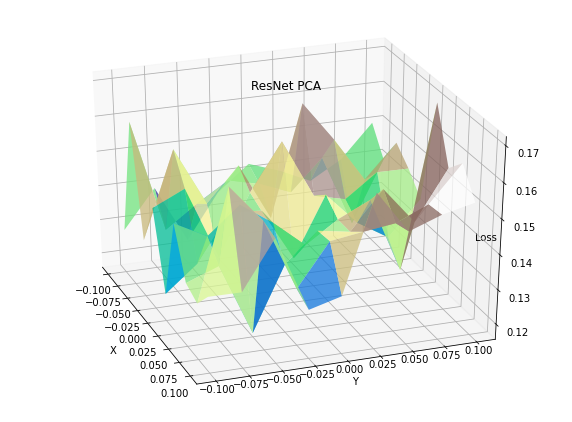

X data:
[[-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2

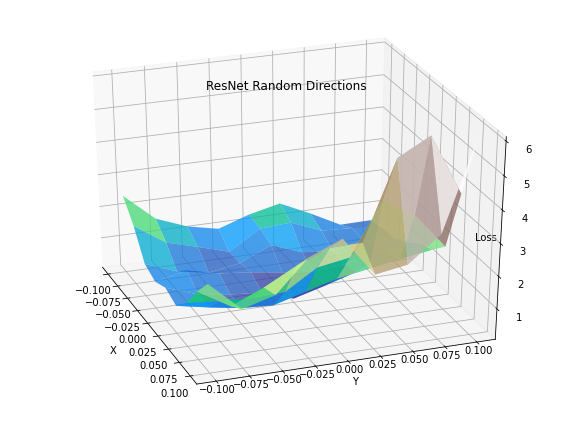

X data:
[[-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2

Downloading: "https://download.pytorch.org/models/vgg11-8a719046.pth" to /root/.cache/torch/hub/checkpoints/vgg11-8a719046.pth


  0%|          | 0.00/507M [00:00<?, ?B/s]

epoch: 0
Training
Train Loss: 0.3633, Train Acc: 0.15
Test Loss: 0.2289, Test Acc: 0.17
Training
Train Loss: 0.2188, Train Acc: 0.25
Training
Train Loss: 0.2023, Train Acc: 0.28


/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


Test Loss: 0.1849, Test Acc: 0.35
Test Loss: 0.1628, Test Acc: 0.45
Test Loss: 0.1775, Test Acc: 0.36
Test Loss: 0.1871, Test Acc: 0.29
Test Loss: 0.1776, Test Acc: 0.41
Test Loss: 0.1779, Test Acc: 0.30
Test Loss: 0.1604, Test Acc: 0.48
Test Loss: 0.1651, Test Acc: 0.41
Test Loss: 0.1720, Test Acc: 0.41
Test Loss: 0.1744, Test Acc: 0.36
Test Loss: 0.1876, Test Acc: 0.36
Test Loss: 0.1826, Test Acc: 0.30
Test Loss: 0.1823, Test Acc: 0.33
Test Loss: 0.1735, Test Acc: 0.38
Test Loss: 0.1756, Test Acc: 0.46
Test Loss: 0.1688, Test Acc: 0.39
Test Loss: 0.1851, Test Acc: 0.31
Test Loss: 0.1880, Test Acc: 0.37
Test Loss: 0.1785, Test Acc: 0.40
Test Loss: 0.1554, Test Acc: 0.42
Test Loss: 0.1745, Test Acc: 0.38
Test Loss: 0.1679, Test Acc: 0.35
Test Loss: 0.1778, Test Acc: 0.37
Test Loss: 0.1851, Test Acc: 0.36
Test Loss: 0.1674, Test Acc: 0.41
Test Loss: 0.1677, Test Acc: 0.42
Test Loss: 0.1669, Test Acc: 0.44
Test Loss: 0.1596, Test Acc: 0.41
Test Loss: 0.1577, Test Acc: 0.47
Test Loss: 0.1

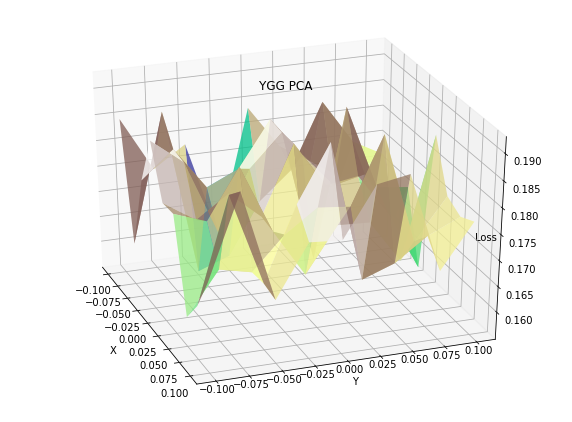

X data:
[[-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2

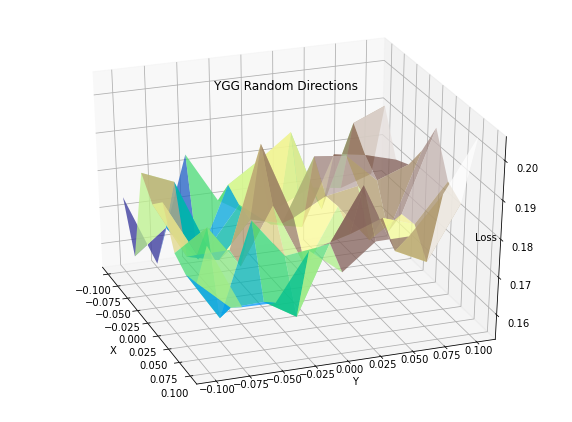

X data:
[[-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2.50000000e-02  5.00000000e-02  7.50000000e-02
   1.00000000e-01]
 [-1.00000000e-01 -7.50000000e-02 -5.00000000e-02 -2.50000000e-02
  -2.77555756e-17  2

In [49]:
training_data, testing_data = get_data()
training_loader, testing_loader = get_loaders(training_data, testing_data, 10)
classes = training_data.classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()

create_ResNet_loss_landscapes(training_loader, testing_loader, device)
create_VGG_loss_landscapes(training_loader, testing_loader, device)